# Fault Tolerant Steane Code

If there is a file import error make sure you are in the correct path

In [ ]:
import sys
sys.path.append('..')   # the `general_qec` package sits above us

In [ ]:
import numpy as np
import random
from general_qec.qec_helpers import *
from general_qec.gates import *
from general_qec.errors import *
from circuit_specific.fault_tolerant_steane import *
from circuit_specific.steane_helpers import *

It is important to note that when we measure the logical states of our qubit systems we will only actually "see" one of the states that make up our superposition terms of our qubit system state. This will happen in this notebooks but it is important to keep in mind that it is only for example's sake.

For example, if our state is $\vert\psi\rangle = \alpha\vert000\rangle + \beta\vert111\rangle$ we will either measure $\vert000\rangle$ or $\vert111\rangle$, never both! 

Another useful example that well come across is when we use ancilla qubits and measure them, collapsing our state. Lets say our state is $\vert\psi\rangle = \alpha_1\vert00001\rangle + \alpha_1\vert00010\rangle + \beta_2\vert11101\rangle + \beta_2\vert11110\rangle$. And lets say we measure our two ancilla qubits at the end (right side of our bit representation). The the states we would get are $\vert\psi\rangle = \gamma_1\vert00001\rangle + \lambda_1\vert11101\rangle$ or $\vert\psi\rangle = \gamma_2\vert00010\rangle + \lambda_2\vert11110\rangle$, but again never both!

In our notebooks, we just display this information to show the current quantum state although, physically, this would never be possible.

In this notebook we will notice however that after our measurement we will collapse the state of our ancilla qubits before continuing in the circuit.

## Contents
1. [Introduction](#introduction)
2. [Setting up our fault tolerant circuit](#setup)
    1. [The full fault tolerant initialization circuit](#fullsetup)
3. [Implementing fault tolerant state initialization](#implement)
    1. [Fault tolerant ancilla block](#ancilla)
    2. [Couple the data block to the ancilla block](#couple)
    3. [Measuring stabilizer operators and applying corrections](#measure)


## 1. Introduction <a id='introduction'></a>

Now we will look at a fault tolerant implementation of the logical state preparation for the `[[7, 1, 3]]` Steane code. We will only consider the propogation of a single error during the preparation for now, since any more than one error is outside the capabilities of the Steane code. 

In order to construct a fault tolerant state preparation circuit, we must measure the stabilizer operators in a fault tolerant way. There are many ways to do this, but in our case we will follow the circuit layout that <u>Devitt et al. - 2013 - Quantum Error Correction for Beginners</u> proposes.


## 2. Setting up our fault tolerant circuit <a id='setup'></a>

In this case we will use four ancilla qubits (rather than three lik previously) and prepare them in the state $\frac{1}{\sqrt2} (\vert0000\rangle + \vert1111\rangle)$. 

This state can be reached by applying a hadamard to one of the ancillas and then implementing a set of CNOT gates between them. Each ancilla will be used to control a single CNOT gate operation on four qubits (applying the stabilizer operator). After which we will measure the ancilla block is decoded and measured. This will ensure that any X error will only propogate to a single qubit in the data block, which we can later correct for. This is shown in the figure below.

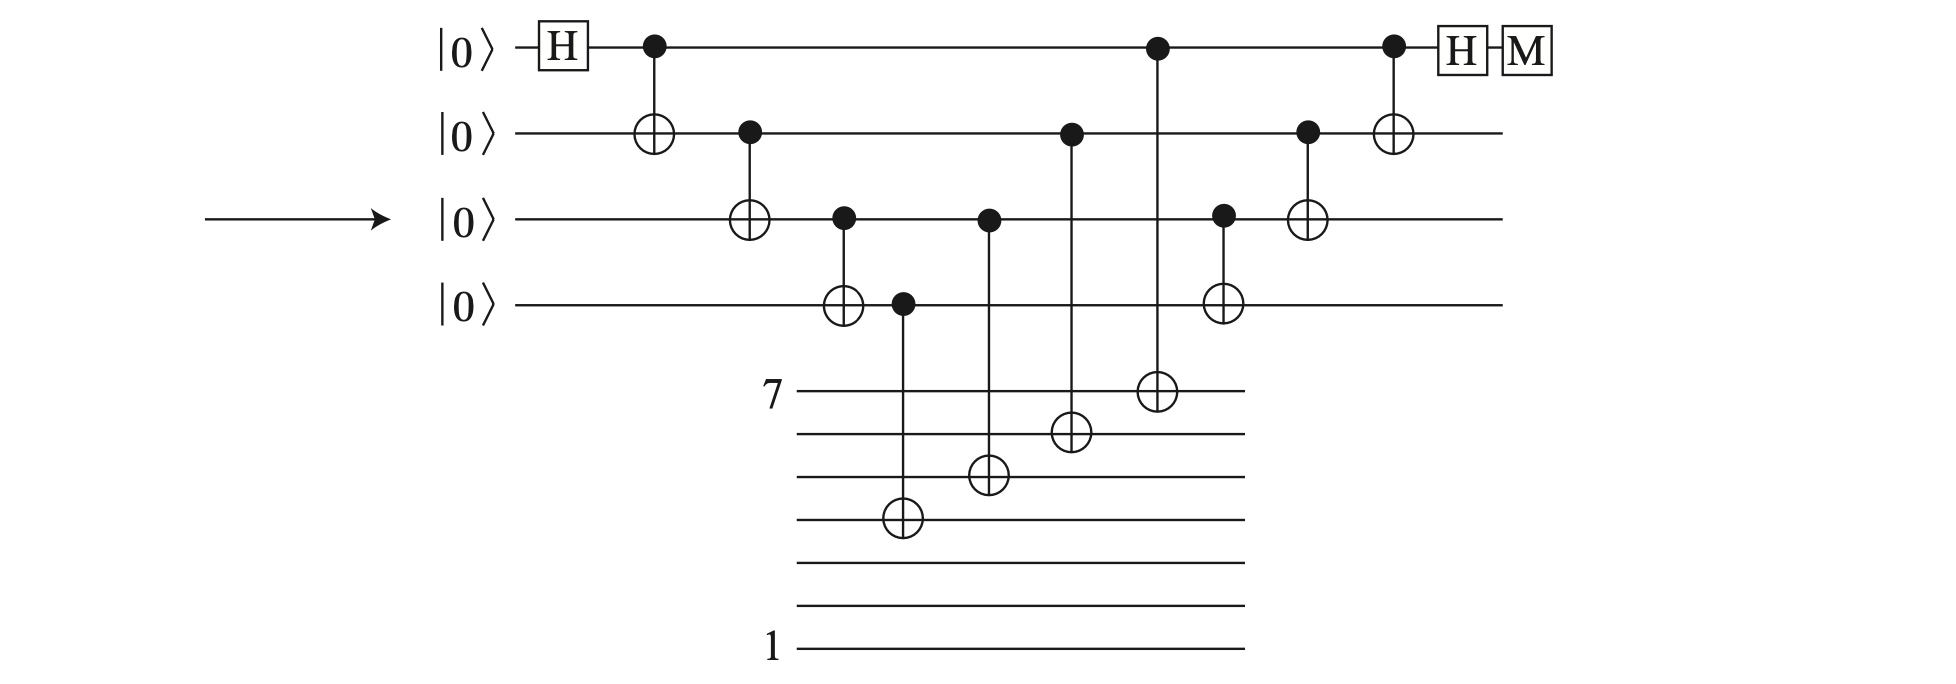

One issue that we face however, is the fact that a single X error in the ancilla block can still propogate to multiple ancilla, which will then lead to an incorrect operation on the data block. In the figure above if an error occurs on the qubit with the arrow, then both that qubit and the one below will have an error. We can look through all the possible single error locations to find the follwoing possible states:

* No error or at most one bit flip error:

$$ \vert A\rangle_1 = \frac{1}{\sqrt2}(\vert0000\rangle + \vert1111\rangle),\quad \vert A\rangle_2 = \frac{1}{\sqrt2}(\vert0100\rangle + \vert1011\rangle),\quad \vert A\rangle_3 = \frac{1}{\sqrt2}(\vert0010\rangle + \vert1101\rangle), \vert A\rangle_4 = \frac{1}{\sqrt2}(\vert0001\rangle + \vert1110\rangle)$$ 

* Multiple errors:

$$ \vert A\rangle_5 = \frac{1}{\sqrt2}(\vert0111\rangle + \vert1000\rangle),\quad \vert A\rangle_6 = \frac{1}{\sqrt2}(\vert0011\rangle + \vert0011\rangle)$$

As we can see from above, multiple errors may occur through the process of CNOT gates copying them. However, the only state that needs to be fixed is the last state since $\vert A\rangle_5$ is the same as having a single bit flip error. But, $\vert A\rangle_6$ has two bit flip errors on the ancilla state. In order to correct for this a fifth ancilla verification qubit is added to perform a parity check on the ancilla block. If this ancilla is measured to be $\vert0\rangle$ then the block is coupled to the data block. However, if the fifth ancilla is measured to be $\vert1\rangle$ then an error occured on the verification qubit, or the ancilla state was prepared in $\vert A\rangle_5$ or $\vert A\rangle_5$ states. Either way, we will reinitialize the ancilla block and prepare it again until we read out a $\vert0\rangle$ from the fifth verification qubit. This circuit is shown below.

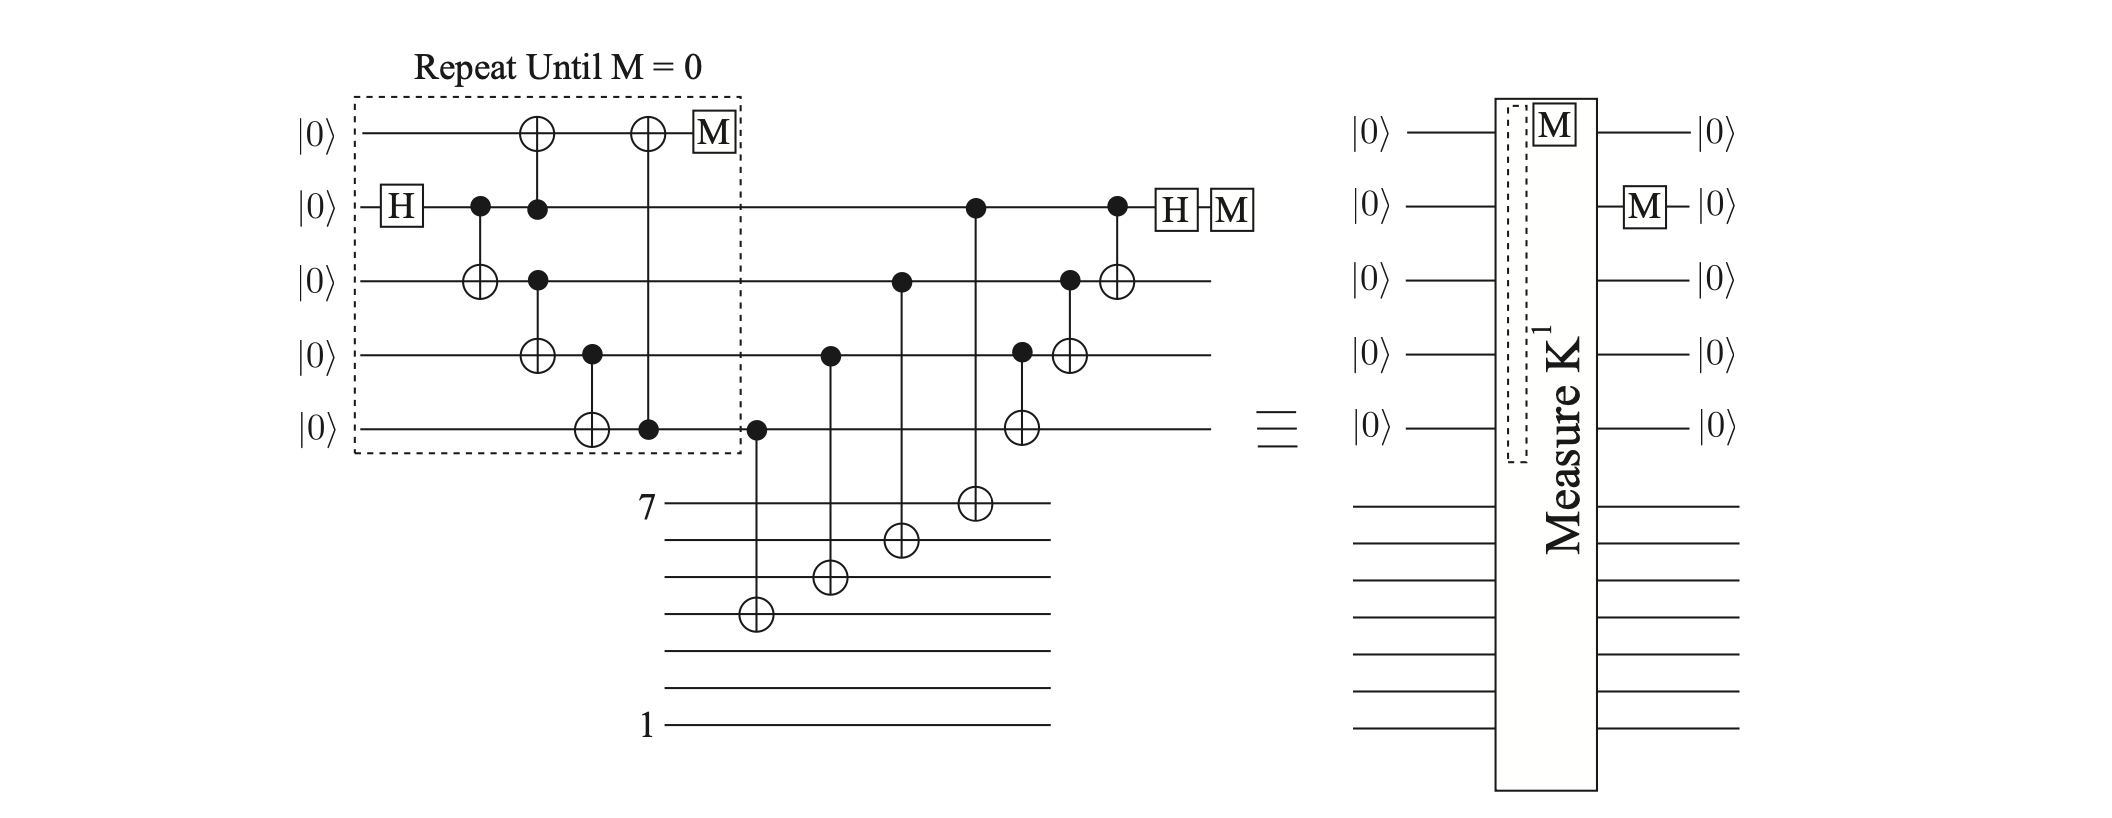

On the other hand, Z errors cannot be corrected this way and will simply go through to the final measurement. Thus, to protect against this, we measure each stabilizer 2-3 times and a majority vote of the measurement result is made. 

If more than one error occurs, that the Steane code should not theoretically be able to handle (see <u>03. Stabilizer codes and steane code</u>), then a a higher order process has occured. Basically if the first or second measurement result was corrupted by a Z error, then the third measurement should not contain any errors unless a higher order process has occured. From this we can ignore this possibility and assume that the third measurement does not have any errors. 

## A. The full fault tolerant initialization circuit <a id='fullsetup'></a>

The new circuit is depicted below, and we can see that we will now require a total of 12 qubits. (7 data and 5 ancilla) Although it looks complex, remember that we are simply applying the above circuit multiple times and measuring different stabilzer operators. 

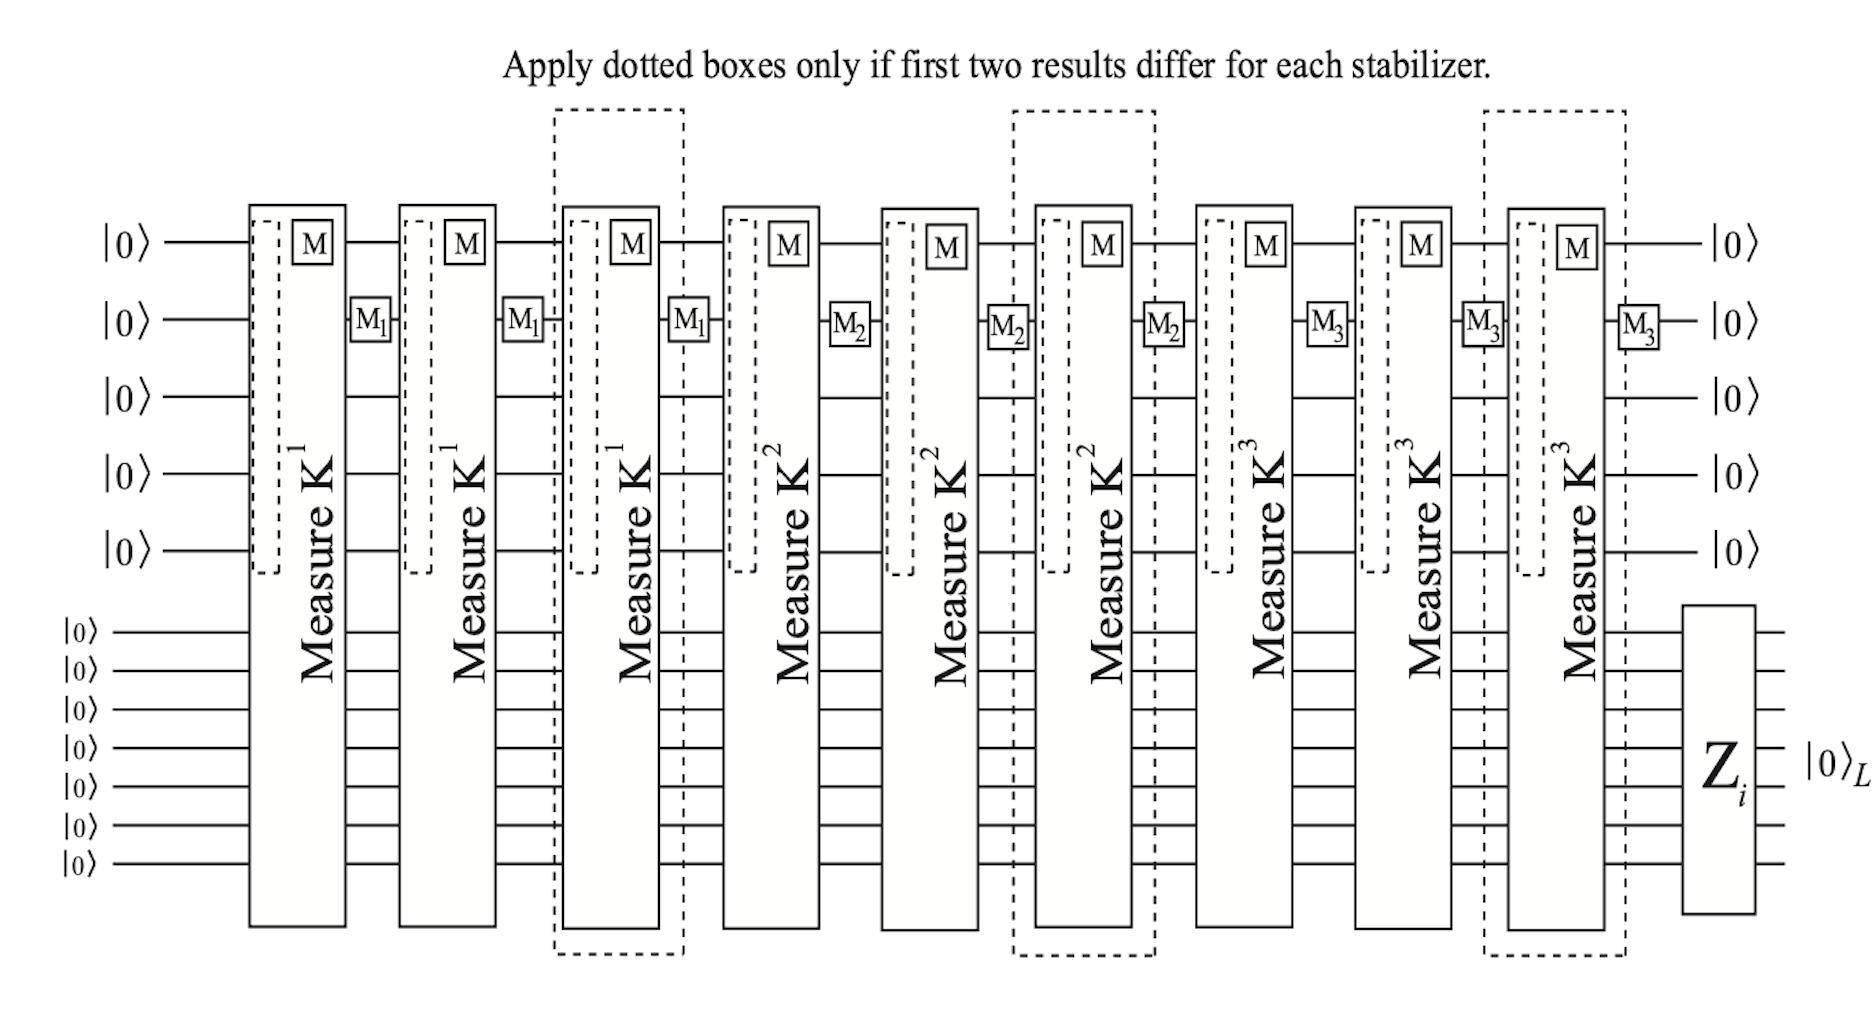

## 3. Implementing fault tolerant state initialization <a id='implement'></a>

### A. Fault tolerant ancilla block <a id='ancilla'></a>

First we need to initialize the ancilla block as discussed above. The fault_tolerant_ancilla() function initializes the logical ancilla state and checks the fifth qubit. If the fifth ancilla qubit is a 1, the state will be reinitialized and encoded again until we measure 0 from the fifth ancilla qubit. Additionally, there may be some phase error exibited because this function introduced a phase and bit flip error. 

In [ ]:
zero = np.array([1, 0])
one = np.array([0, 1])

# initialize data block
# data_state = np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, one))))))
data_state = np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero))))))

# initialize ancilla block to |00000>
ancilla_block = np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero))))

# combine both states
initial_state = np.kron(data_state, ancilla_block)

# initialize a fault tolerant ancilla state
initial_state = fault_tolerant_ancilla(initial_state)

# Display the current state (with ancillas)
print('Initialized logical state: (by amplitude) ')
print_state_info(initial_state, 12)

### B. Couple the data block to the ancilla block<a id='couple'></a>

Now we can couple the ancilla block to the data block and perform the stabilizer operations. Here is an example of how we would perform the $K^1$ operator measurement:

In [ ]:
# Perform Stabilizer operation (in this case we will do K1 as an example like the circuit in section 2)
h = np.kron(np.identity(2**10), np.kron(hadamard, np.identity(2)))
cnot_gates = np.dot(np.dot(CNOT(10, 9, 12), np.dot(CNOT(9, 8, 12), CNOT(8, 7, 12))), np.dot(
    CNOT(7, 3, 12), np.dot(CNOT(8, 4, 12), np.dot(CNOT(9, 5, 12), CNOT(10, 6, 12)))))

final_state = np.dot(cnot_gates, initial_state)

final_state = np.dot(h, final_state)

# Display the current state (with ancillas)
print('Final logical state: (by amplitude) ')
print_state_info(final_state, 12)

In [ ]:
# normalize and collapse the ancilla qubits
collapsed_state = np.sqrt(2) * collapse_ancilla(final_state, 5) 
print('Collapse the ancilla qubits: ')
print_state_info(collapsed_state, 12)
print(' - - - ')
reset_state = ancilla_reset(collapsed_state, 5) # Reset the ancilla qubits if needed
print('Reset ancilla qubits: ')
print_state_info(reset_state, 12)

### C. Measuring stabilizer operators and applying corrections <a id='measure'></a>

Here we sequentially measure the Z and X correction stabilizer operators for the Steane Code.  We do this by first applying $K^1$, $K^2$, and $K^3$ operators fault tolerantly and then applying the proper phase correction. Next we apply and correct bit flips using $K^4$, $K^5$, and $K^6$ operators fault tolerantly.

Remember that the initialization and error correction schemes for the steane code are the same. So we can just repeat the same process when we want to correct for errors.

Note that the errors occuring on the ancilla are X and Z errors. X errors can happen at any stabilizer operator, however Z errors only happen for 1 of the 3 times we measure each stabilzer operator. This is because the Z error propogates to the end and any additional Z error would be a higher order error, which means that it is outside of the capabilities of the Steane Code.

We run a "best $2/3$" measurement scheme for each stabilizer operator to help correct for possible Z errors propogating in ancilla initialization.

In [ ]:
zero = np.array([1, 0])
one = np.array([0, 1])
superpos = 1/np.sqrt(2) * np.array([1, 1])
# initialize data block
# data_state = np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, one))))))
data_state = np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero))))))
# data_state = np.kron(superpos, np.kron(superpos, np.kron(superpos, np.kron(
#     superpos, np.kron(superpos, np.kron(superpos, superpos))))))

# initialize ancilla block to |00000>
ancilla_block = np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero))))

# combine both states
initial_state = np.kron(data_state, ancilla_block)

print('Initial State:')
print_state_info(initial_state, 12)

In [ ]:
# Initialize our logical state
logical_state = fault_tolerant_steane_code(initial_state)

In [ ]:
# Apply a random phase and random bit error on one of your 7 data qubits
corrected_vector_state = ancilla_reset(logical_state, 5)
errored_state = random_qubit_x_error(random_qubit_z_error(corrected_vector_state, [0, 6])[0], [1, 7])[0]
print('State after phase and bit flip error is applied on data block:')
print_state_info(errored_state, 12)

In [ ]:
# Correct for our errors fault tolerantly
corrected_state = fault_tolerant_steane_code(errored_state)